In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split  # Para separar en Train / Test

from scipy.stats import shapiro  # Para test de normalidad de Shapiro
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler  # Para escalar
from sklearn.preprocessing import OneHotEncoder # Para convertir variables ordinales en binarias.

from sklearn import linear_model  # Regresión lineal
from sklearn.linear_model import LinearRegression  # Si no importamos esto también, por algún motivo falla Gridsearch.

from sklearn.ensemble import RandomForestRegressor  # Regresión en Random Forest

from sklearn.metrics import mean_squared_error, r2_score  # Para MSE y R^2
from sklearn.model_selection import GridSearchCV  # Para buscar parámetros optimizados


# Para validación cruzada
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib.pyplot as plt


Mostramos la información sobre el dataset:

In [2]:
info = open(r'housing data description.txt', 'r')
print(info.read())

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

Creamos y añadimos las columnas de título para crear un dataframe de pandas a partir del .csv:

In [3]:
col_title = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

In [4]:
pisos_Boston = pd.read_csv(r'housing data.csv', names = col_title)

In [5]:
pisos_Boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


Observamos si hay variables con valores nulos y vemos que no:

In [6]:
pisos_Boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Veamos los tipos de variables:

In [7]:
pisos_Boston.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Las variables 'CHAS' y 'RAD' parecen ser categóricas:

In [8]:
# Variable "dummy" relacionada con la vecindad o no al río Charles.
print(pisos_Boston['CHAS'].unique())   # Toma valores de cero o uno: valor uno si los pisos son rivereños al río Charles.

[0 1]


In [9]:
# Categoría relacionada con la accesibilidad a autopista radial.
print(pisos_Boston['RAD'].unique())    
# Toma valores del uno al ocho, o valor veinticuatro. Podría parecer ordinal, pero el veinticuatro me hace dudar...

[ 1  2  3  5  4  8  6  7 24]


En la posterior regresión, dado que "CHAS" ya es una variable binaria, en principio se puede dejar tal cual.
Con respecto a "RAD", podemos hacer "hot encoding" para convertir esta columna en una serie de variables binarias.

Observamos la descripción estadística de las variables (excluyendo las categóricas y la variable "target").

In [10]:
pisos_Boston.drop(columns=['CHAS', 'RAD', 'MEDV']).describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000


In [11]:
pisos_Boston.duplicated().sum()   # No hay filas duplicadas.

0

Todo el resto son floats. Como no hay "missing data", ni duplicados, simplemente haremos las operaciones necesarias de transformación de los datos (algún tipo de estandarización/normalización, etc.), porque lo que sí tienen son rangos de valores bastante diferentes.

Observamos también el tipo de distribución, y la presencia o ausencia de outliers:

CRIM


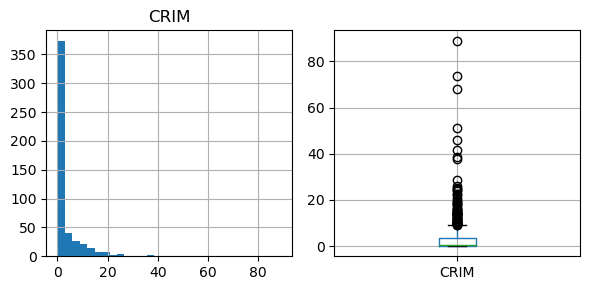

ZN


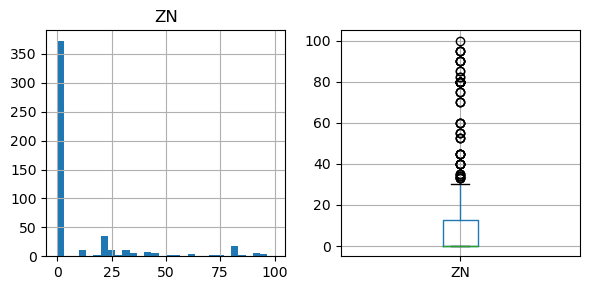

INDUS


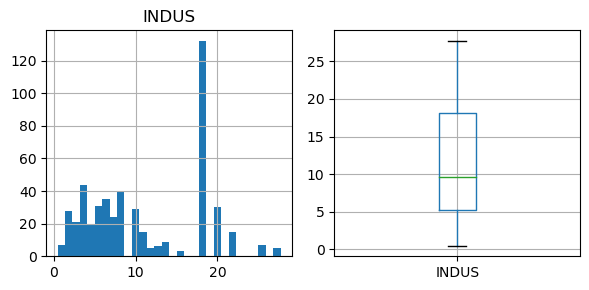

NOX


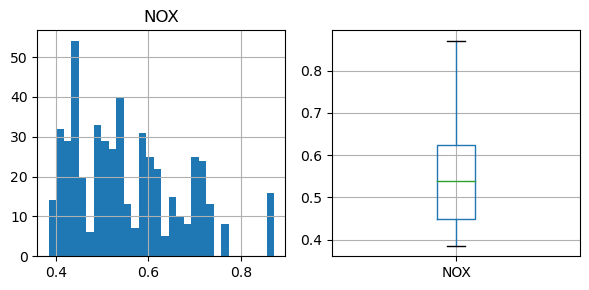

RM


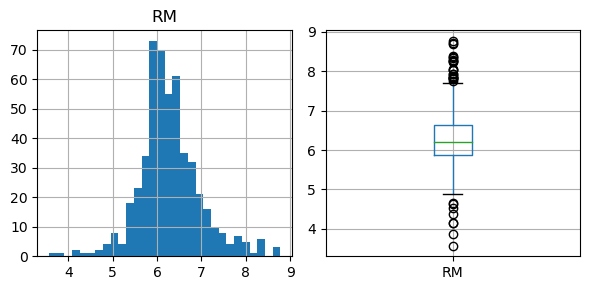

AGE


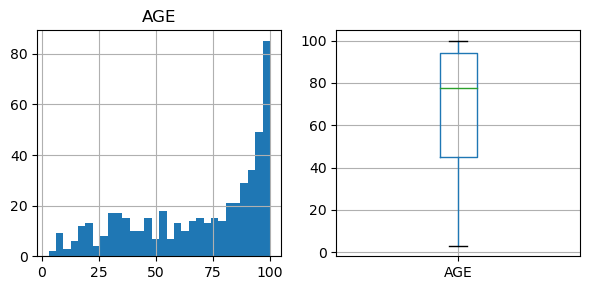

DIS


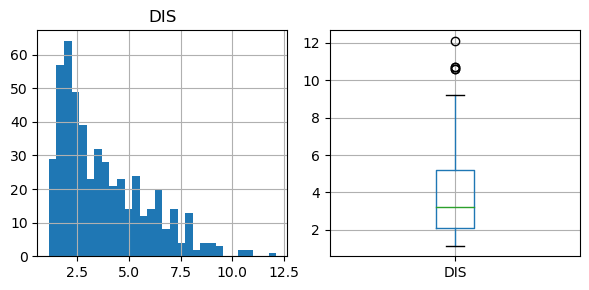

TAX


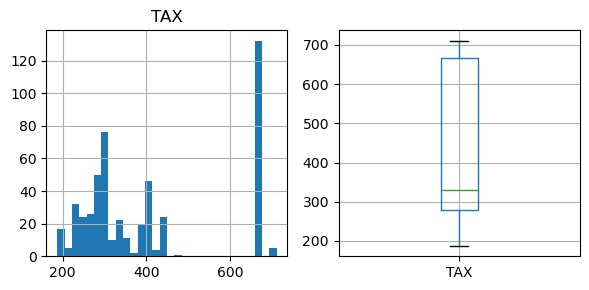

PTRATIO


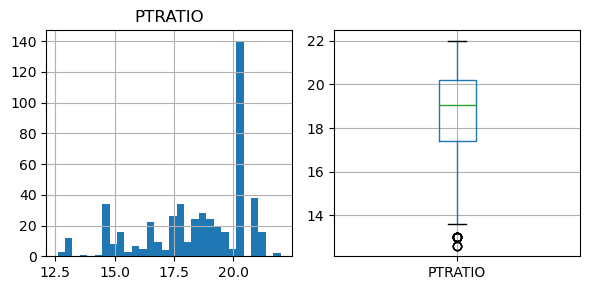

B


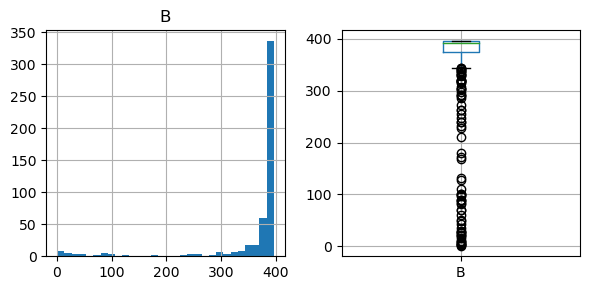

LSTAT


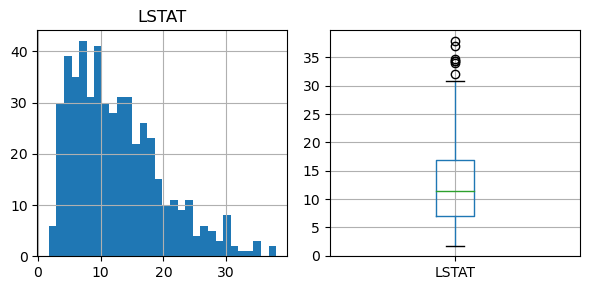

In [12]:
for col in pisos_Boston.drop(columns=['CHAS', 'RAD', 'MEDV']).columns:
    print(col)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

    # Plot a histogram on the first subplot
    pisos_Boston.hist(column=col, bins=30, ax=axs[0])

    # Plot a boxplot on the second subplot
    pisos_Boston.boxplot(column=col, ax=axs[1])

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

Solo 'RM' parece que pudiera ser normal a simple vista; pero lo confirmamos mediante un test de normalidad (Shapiro):

In [13]:
gaussian_columns = []
# Test de normalidad de Shapiro-Wilk
for column in pisos_Boston.drop(["CHAS", "RAD", "MEDV"], axis=1).columns:
    print(column)
    stat, p = shapiro(pisos_Boston[column])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:  # Con nivel de significación 0,05: si p está por encima de 0,05 probablemente SÍ tenemos distribución gaussiana (a.k.a. normal).
        gaussian_columns.append(column)
        print('Probably Gaussian\n')
    else:
        print('Probably not Gaussian\n')  # Con nivel de significación 0,05: si p está por debajo de 0,05 probablemente NO tenemos distribución normal o gaussiana.
    # Nota: ejemplo adaptado de:  https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

CRIM
stat=0.450, p=0.000
Probably not Gaussian

ZN
stat=0.556, p=0.000
Probably not Gaussian

INDUS
stat=0.900, p=0.000
Probably not Gaussian

NOX
stat=0.936, p=0.000
Probably not Gaussian

RM
stat=0.961, p=0.000
Probably not Gaussian

AGE
stat=0.892, p=0.000
Probably not Gaussian

DIS
stat=0.903, p=0.000
Probably not Gaussian

TAX
stat=0.815, p=0.000
Probably not Gaussian

PTRATIO
stat=0.904, p=0.000
Probably not Gaussian

B
stat=0.477, p=0.000
Probably not Gaussian

LSTAT
stat=0.937, p=0.000
Probably not Gaussian



In [14]:
gaussian_columns

[]

Finalmente, parece que no hay ninguna variable que siga una distribución gaussiana.
Por lo tanto aplicaremos las siguientes transformaciones:

In [15]:
# No normales y con outliers: "CRIM", "ZN", "RM", "DIS", "LSTAT", "B".
for_robust = ["CRIM", "ZN", "RM", "DIS", "LSTAT", "B"]
robust_sc = RobustScaler()

# No normales pero sin outliers:"INDUS", "NOX", "TAX", "PTRATIO", "AGE".
for_minmax = ["INDUS", "NOX", "TAX", "PTRATIO", "AGE"]
minmax_sc = MinMaxScaler()

Antes de continuar, aplicamos los diversos escalados a nuestras columnas del dataframe pisos_boston.

In [16]:
# Para no sobreescribir el dataframe original, creamos una copia en la que guardaremos las variables escaladas.
pisos_Boston_escalado = pisos_Boston.copy()

for column in pisos_Boston.drop(['MEDV'], axis=1).columns:
    if column in for_robust:
        pisos_Boston_escalado[column] = robust_sc.fit_transform(pisos_Boston[[column]])
    elif column in for_minmax:
        pisos_Boston_escalado[column] = minmax_sc.fit_transform(pisos_Boston[[column]])
    else:
        print("La variable categórica " + column + " la trataremos aparte.")

La variable categórica CHAS la trataremos aparte.
La variable categórica RAD la trataremos aparte.


In [17]:
pisos_Boston_escalado

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.069593,1.44,0.067815,0,0.314815,0.496612,0.641607,0.285777,1,0.208015,0.287234,0.261902,-0.637681,24.0
1,-0.063755,0.00,0.242302,0,0.172840,0.287940,0.782698,0.569789,2,0.104962,0.553191,0.261902,-0.221889,21.6
2,-0.063760,0.00,0.242302,0,0.172840,1.323171,0.599382,0.569789,2,0.104962,0.553191,0.066675,-0.732634,34.7
3,-0.062347,0.00,0.063050,0,0.150206,1.069783,0.441813,0.924391,3,0.066794,0.648936,0.153016,-0.841579,33.4
4,-0.052144,0.00,0.063050,0,0.150206,1.271680,0.528321,0.924391,3,0.066794,0.648936,0.261902,-0.602699,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.521003,0.681771,-0.236007,1,0.164122,0.893617,0.026382,-0.168916,22.4
502,-0.058759,0.00,0.420455,0,0.386831,-0.119919,0.760041,-0.297887,1,0.164122,0.893617,0.261902,-0.227886,20.6
503,-0.054450,0.00,0.420455,0,0.386831,1.039973,0.907312,-0.336744,1,0.164122,0.893617,0.261902,-0.571714,23.9
504,-0.040867,0.00,0.420455,0,0.386831,0.793360,0.889804,-0.265053,1,0.164122,0.893617,0.096414,-0.487756,22.0


Abordamos ahora las variables categóricas.

Por un lado, a la variable "CHAS" en realidad no hay que hacerle nada: ya es una variable categórica.

En cambio, no me queda muy claro si la variable "RAD" es ordinal (aunque podría ser) o si son categorías independientes, cada una con sus características. Mi interpretación inicial fue que eran dummys, pero para considerarlos ordinales haríamos así:

In [18]:
# Código si no es ordinal: (YA NO LO USAMOS)
# pisos_Boston_escalado = pd.concat([pisos_Boston_escalado, pd.get_dummies(pisos_Boston_escalado['RAD'], prefix='Dummy number'), ], axis=1)
# Nota: sin convertir explícitamente el df['RAD'] a (int), aunque ya era un Numpy Int, no daba ceros y unos sino True/False.

In [19]:
#Código si lo consideramos ordinal:

# Creación de instancia OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# El encoder hace "fit_transform" sobre la columna ordinal de interés 'RAD' column y "codifica" los valores
RAD_encoded = encoder.fit_transform(pisos_Boston_escalado[['RAD']])

# Convertir la codificación obtenida a dataframe.
RAD_encoded_df = pd.DataFrame(RAD_encoded, columns=encoder.get_feature_names_out(['RAD']))


C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
RAD_encoded_df

,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
501,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para evitar multicolinearidad, eliminamos una de las columnas. Eliminamos la uno, para que no dé la impresión de que nos hemos olvidado de eliminar una.

In [21]:
RAD_encoded = RAD_encoded_df.drop(['RAD_1'], axis=1)

In [22]:
RAD_encoded

,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Concatenación del DataFrame con el DataFrame del One Hot Encoding. Eliminamos también la columna "RAD" original
pisos_Boston_escalado = pd.concat([pisos_Boston_escalado.drop(['RAD'], axis = 1), RAD_encoded], axis=1)


In [24]:
pisos_Boston_escalado

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,LSTAT,MEDV,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,0.067815,0,0.314815,0.496612,0.641607,0.285777,0.208015,0.287234,...,-0.637681,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.063755,0.00,0.242302,0,0.172840,0.287940,0.782698,0.569789,0.104962,0.553191,...,-0.221889,21.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.063760,0.00,0.242302,0,0.172840,1.323171,0.599382,0.569789,0.104962,0.553191,...,-0.732634,34.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.062347,0.00,0.063050,0,0.150206,1.069783,0.441813,0.924391,0.066794,0.648936,...,-0.841579,33.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.052144,0.00,0.063050,0,0.150206,1.271680,0.528321,0.924391,0.066794,0.648936,...,-0.602699,36.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.521003,0.681771,-0.236007,0.164122,0.893617,...,-0.168916,22.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,-0.058759,0.00,0.420455,0,0.386831,-0.119919,0.760041,-0.297887,0.164122,0.893617,...,-0.227886,20.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,-0.054450,0.00,0.420455,0,0.386831,1.039973,0.907312,-0.336744,0.164122,0.893617,...,-0.571714,23.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,-0.040867,0.00,0.420455,0,0.386831,0.793360,0.889804,-0.265053,0.164122,0.893617,...,-0.487756,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
pisos_Boston_escalado.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,LSTAT,MEDV,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
count,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,506.000000,506.000000,...,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,9.337910e-01,0.909091,0.391378,0.069170,0.349167,0.103163,0.676364,1.902672e-01,0.422208,0.622929,...,1.292417e-01,22.532806,0.047431,0.075099,0.217391,0.227273,0.051383,0.033597,0.047431,0.260870
std,2.392616e+00,1.865796,0.251479,0.253994,0.238431,0.952056,0.289896,6.818457e-01,0.321636,0.230313,...,7.137493e-01,9.197104,0.212769,0.263812,0.412879,0.419485,0.220997,0.180367,0.212769,0.439543
min,-6.959315e-02,0.000000,0.000000,0.000000,0.000000,-3.587398,0.000000,-6.728244e-01,0.000000,0.000000,...,-9.625187e-01,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.852940e-02,0.000000,0.173387,0.000000,0.131687,-0.437669,0.433831,-3.585445e-01,0.175573,0.510638,...,-4.407796e-01,17.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-7.697835e-18,0.000000,0.338343,0.000000,0.314815,0.000000,0.768280,7.199102e-17,0.272901,0.686170,...,8.847090e-17,21.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.514706e-01,1.000000,0.646628,0.000000,0.491770,0.562331,0.938980,6.414555e-01,0.914122,0.808511,...,5.592204e-01,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.467838e+01,8.000000,1.000000,1.000000,1.000000,3.484417,1.000000,2.888060e+00,1.000000,1.000000,...,2.659670e+00,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ya tenemos los datos pre-tratados.

Representemos lo que tenemos (excluyendo categóricas)

In [26]:
dummys_binarias = ['RAD_1', 'RAD_2', 'RAD_3', 'RAD_4', 'RAD_5', 'RAD_6', 'RAD_7', 'RAD_8', 'RAD_24', 'CHAS']
col_numericas = list()

for column in pisos_Boston_escalado:
    if column not in dummys_binarias:
        col_numericas.append(column)

In [27]:
col_numericas

['CRIM',
 'ZN',
 'INDUS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MEDV']

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


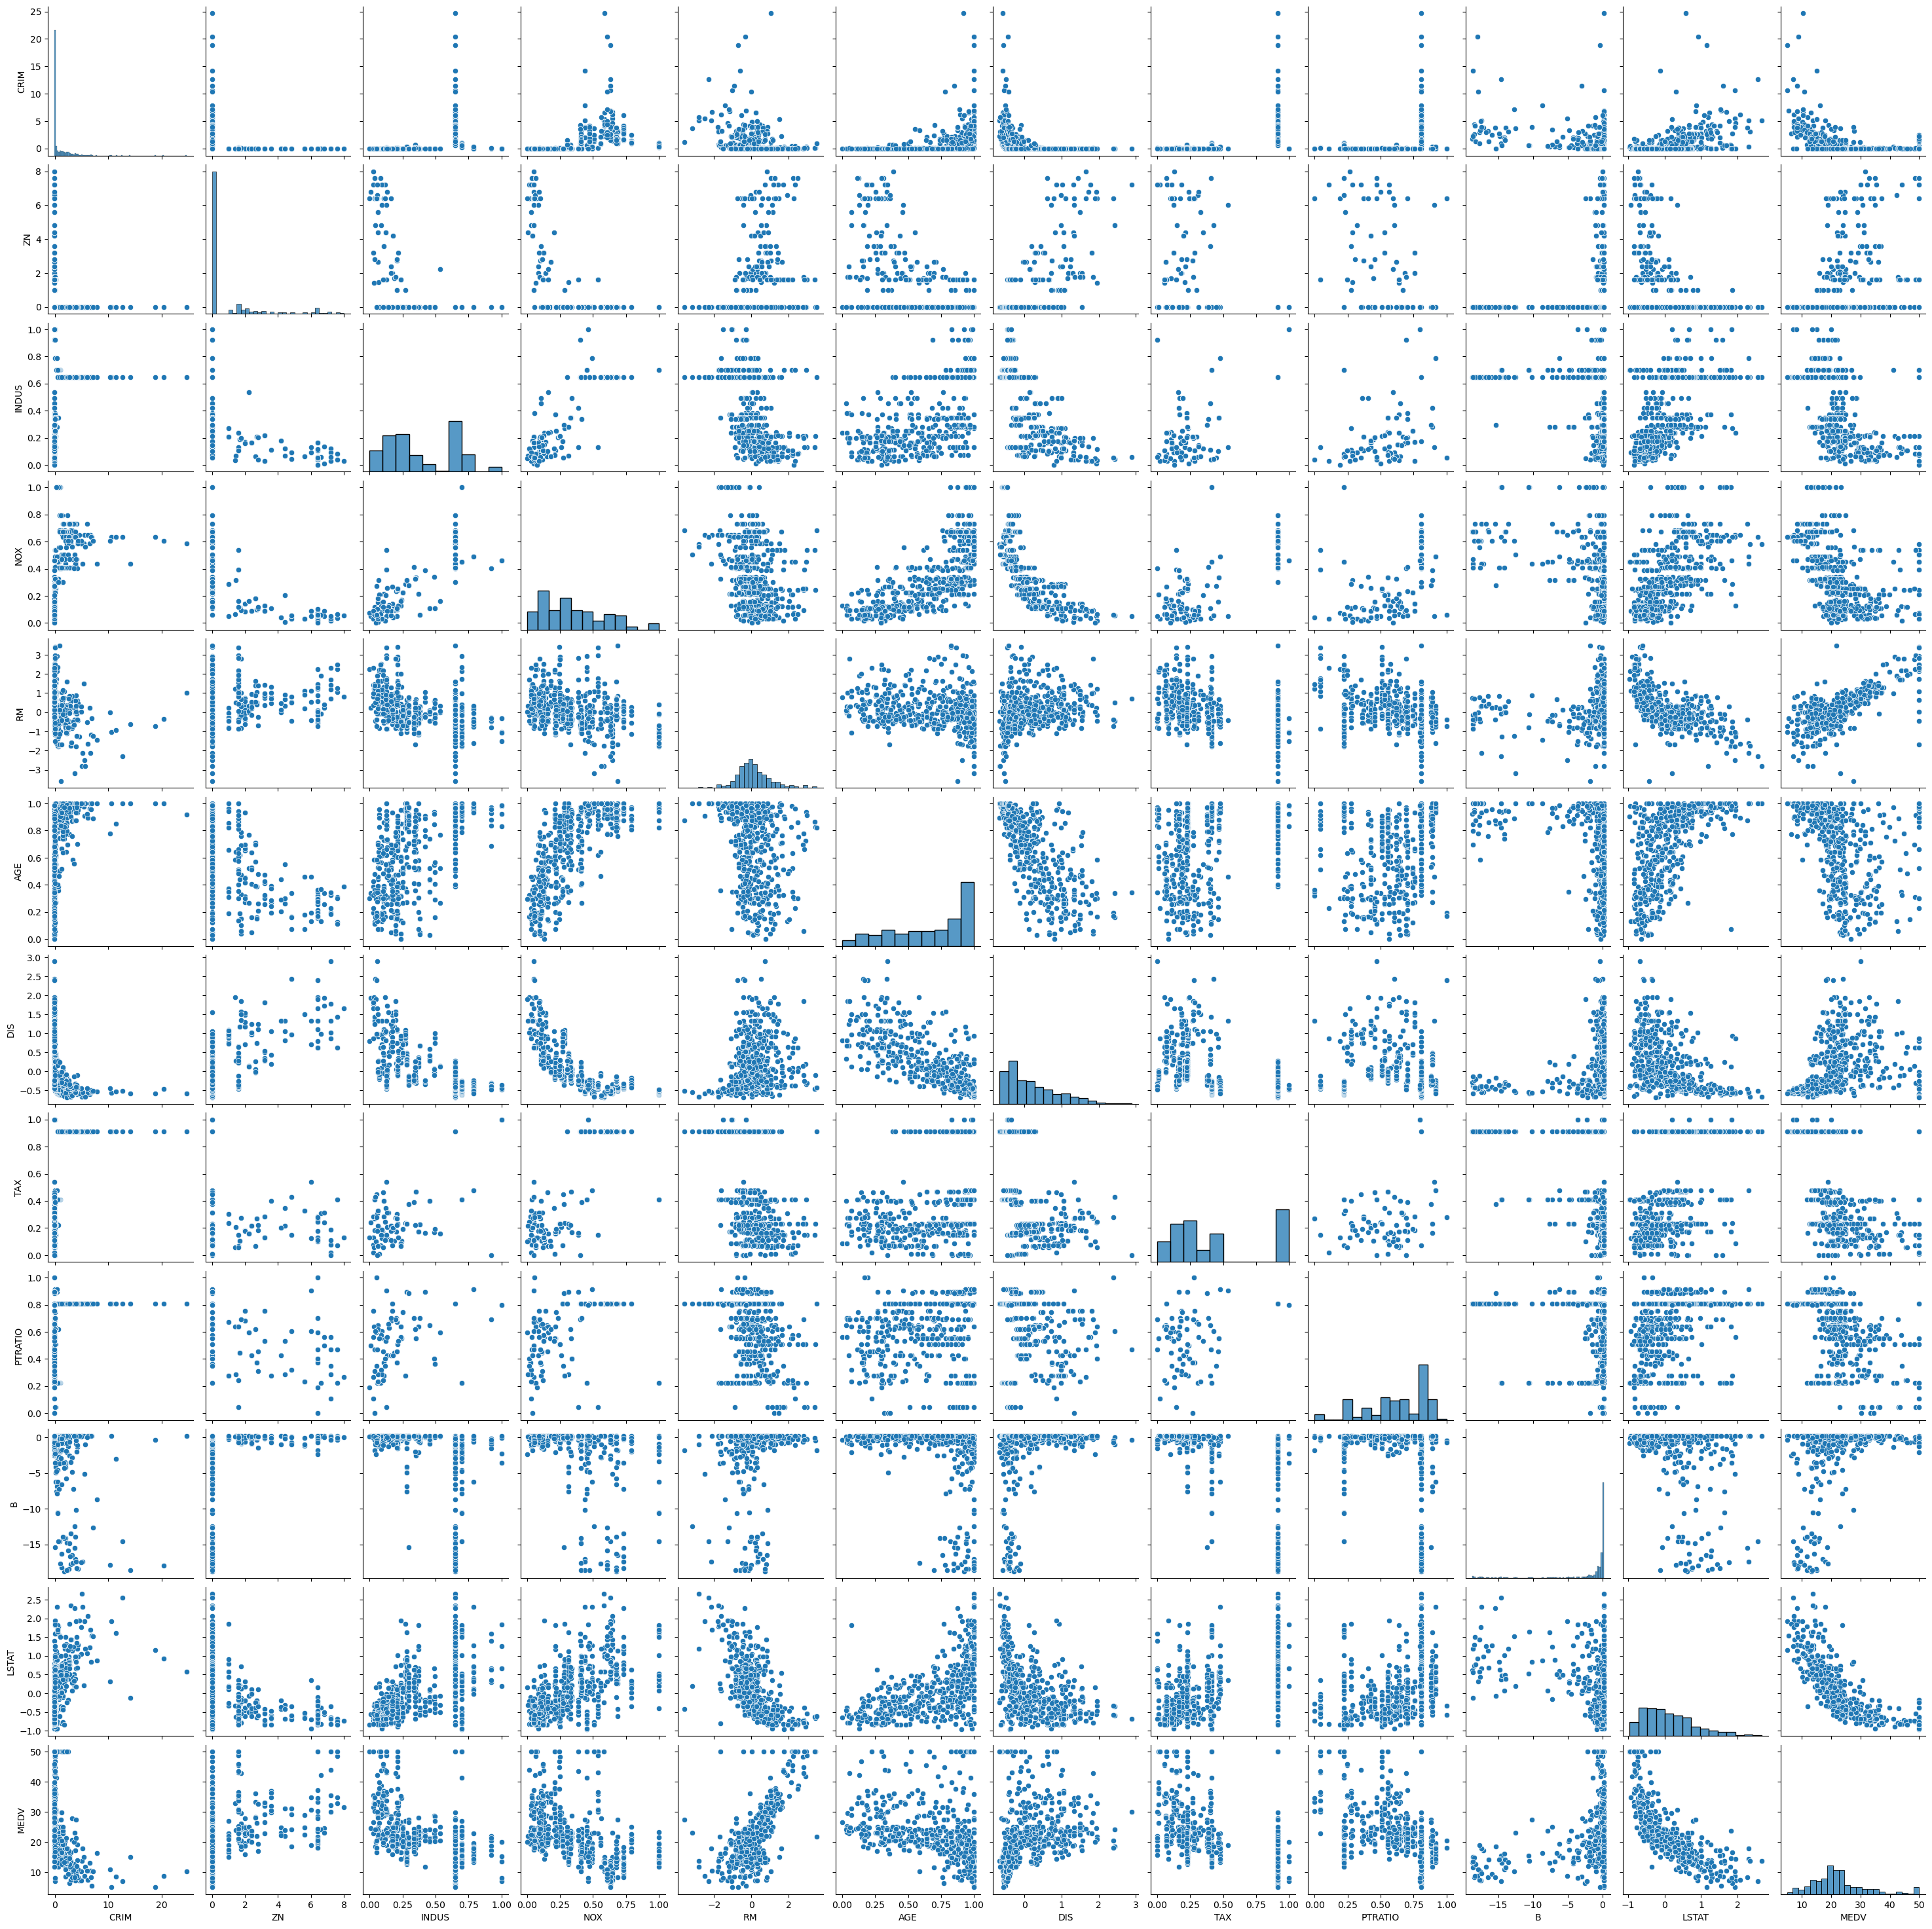

In [28]:
sns.pairplot(pisos_Boston_escalado[col_numericas])

En este pairplot vemos que hay una serie de variables cuya distribución está extremadamente sesgada hacia un lado.
Ejemplos son:
'CRIM', 'ZN' y 'B'.
Otras, tienen sesgos menores.
Solo "RM" se parece (visualmente) un poco a una distribución normal. Un poco menos (también visualmente), la variable target 'MEDV'.

Si nos fijamos en concreto en nuestra variable target, llama la atención que tiene una correlación positiva muy lineal con la variable 'RM' (número de habitaciones), lo cual es muy razonable. Más habitaciones... más precio. Esto será importante más adelante.

Se ven algunas otras correlaciones, no lineales, unas negativas y otras positivas.
Positivas, se ven:
'ZN' (relacionado con la proporción de terrenos residenciales extensos), 'DIS' (relacionado con la distancia a centros de empleo).
Negativas, se ven:
'CRIM' (todo el sentido), 'INDUS' y 'NOX' (más contaminación, malo... también todo el sentido), y 'LSTAT' (porcentaje de población "lower status").
Luego hay otras, ya menos claras.


# Ejercicio 1

Crear como mínimo dos modelos de regresión diferentes para predecir lo mejor posible el precio de las viviendas (MEDV).

Consideraciones:
    
-Eliminaremos la columna objetivo, o sea, la columna del precio mediano, "MEDV" para conformar el grupo de datos "X".

-Emplearemos la columna objetivo eliminada, "MEDV" (que es la variable "target"), como grupo de datos "Y" para entrenar los modelos.

-Separaremos los datos en un grupo de entrenamiento ("train") y un grupo para testing ("test").

Variable "target", Y:

In [29]:
Y = pisos_Boston_escalado["MEDV"]
Y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

Variables "predictoras", X:

In [30]:
X = pisos_Boston_escalado.drop(['MEDV'], axis=1)
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,0.067815,0,0.314815,0.496612,0.641607,0.285777,0.208015,0.287234,0.261902,-0.637681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.063755,0.00,0.242302,0,0.172840,0.287940,0.782698,0.569789,0.104962,0.553191,0.261902,-0.221889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.063760,0.00,0.242302,0,0.172840,1.323171,0.599382,0.569789,0.104962,0.553191,0.066675,-0.732634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.062347,0.00,0.063050,0,0.150206,1.069783,0.441813,0.924391,0.066794,0.648936,0.153016,-0.841579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.052144,0.00,0.063050,0,0.150206,1.271680,0.528321,0.924391,0.066794,0.648936,0.261902,-0.602699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.521003,0.681771,-0.236007,0.164122,0.893617,0.026382,-0.168916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,-0.058759,0.00,0.420455,0,0.386831,-0.119919,0.760041,-0.297887,0.164122,0.893617,0.261902,-0.227886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,-0.054450,0.00,0.420455,0,0.386831,1.039973,0.907312,-0.336744,0.164122,0.893617,0.261902,-0.571714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,-0.040867,0.00,0.420455,0,0.386831,0.793360,0.889804,-0.265053,0.164122,0.893617,0.096414,-0.487756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dividimos los datos en datos para entrenamiento ("train") y datos para testing ("test"):

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Vemos las dimensiones/forma de los cuatro "sets" obtenidos X e Y tanto de entrenamiento como de test:

In [32]:
X_train.shape

(404, 20)

In [33]:
X_test.shape

(102, 20)

In [34]:
Y_train.shape

(404,)

In [35]:
Y_test.shape

(102,)

Definimos el primer modelo, una regresión lineal, y la entrenamos:

In [36]:
regresion_lineal= linear_model.LinearRegression()
regresion_lineal.fit(X_train, Y_train)   # NOTA MENTAL: ¡¡Los modelos solo se entrenan una vez!!

LinearRegression()

In [37]:
Y_pred_lineal = regresion_lineal.predict(X_test)

Estas son sus predicciones:

In [38]:
Y_pred_lineal

array([13.47769218, -6.6869278 , 14.22713013, 21.22907052, 25.97767737,
       33.51123394, 20.78295987, 21.24389751, 20.8168454 , 26.05828837,
       28.77393048, 21.52523602, 41.08365131, 37.65927472, 23.56904517,
       24.01614847, -0.2340088 , 29.95113023, 27.16472501, 24.82851464,
       20.58634001, 21.53082134, 35.98684167, 17.37147757, 13.78787251,
       27.12136189, 21.45858479, 12.33994334,  2.14665754, 33.94737166,
       39.24956208, 24.48216293, 38.57599202, 15.60789436, 19.17366273,
       16.59288462, 24.66463833, 24.21988234, 27.26002323, 34.24670007,
       11.6663432 , 20.77203693, 18.5598158 , 16.34072205, 28.39579338,
       27.61263677, 24.18891959, 14.33590661, 29.8704878 , 30.49976326,
       24.29584756, 18.45951605, 19.4361804 , 34.76529896, 21.13880044,
       14.09565654, 20.76811516, 19.68975795, 32.5582051 , 18.40427418,
       26.89626626, 13.82073211, 20.66546825, 21.77846507, 21.81028059,
       20.29020777, 31.59979808, 41.53688241, 31.16167564, 12.93

Definimos un segundo modelo, un regresor Random Forest, y lo entrenamos:

In [39]:
regresion_rf = RandomForestRegressor(random_state = 42)
regresion_rf.fit(X_train, Y_train)    # Lo mismo: luego NOOOO reentrenamos.

RandomForestRegressor(random_state=42)

Usamos la regresión random forest creada para predecir Y a partir de valores test de X.

In [40]:
Y_pred_rf = regresion_rf.predict(X_test)

In [41]:
Y_pred_rf

array([14.561,  8.577, 13.142, 22.319, 23.518, 28.296, 19.589, 22.838,
       21.043, 22.116, 22.793, 20.52 , 47.106, 43.452, 21.128, 24.667,
       12.945, 23.427, 26.85 , 24.005, 20.211, 21.211, 43.968, 15.328,
       19.089, 21.454, 20.172, 11.826,  9.174, 31.289, 47.479, 21.549,
       47.546, 16.452, 15.556, 15.186, 21.418, 22.607, 21.906, 32.672,
       18.049, 19.924, 20.863, 16.274, 23.911, 25.216, 30.596, 16.328,
       30.05 , 31.067, 23.403, 20.654, 14.321, 35.24 , 21.979, 14.569,
       20.198, 19.529, 32.214, 19.085, 24.682, 12.203, 19.051, 22.447,
       21.62 , 20.401, 27.777, 44.748, 34.292, 16.525, 23.865, 14.951,
       20.96 , 20.57 , 39.714, 20.371, 23.509, 19.241, 20.229, 20.569,
       20.651, 21.524, 42.745, 20.5  , 21.799, 17.113, 22.517, 18.835,
       27.576, 12.842, 32.375, 23.87 , 45.827, 47.488, 20.919, 14.866,
       14.175, 47.812,  9.634, 21.747, 22.1  , 34.446])

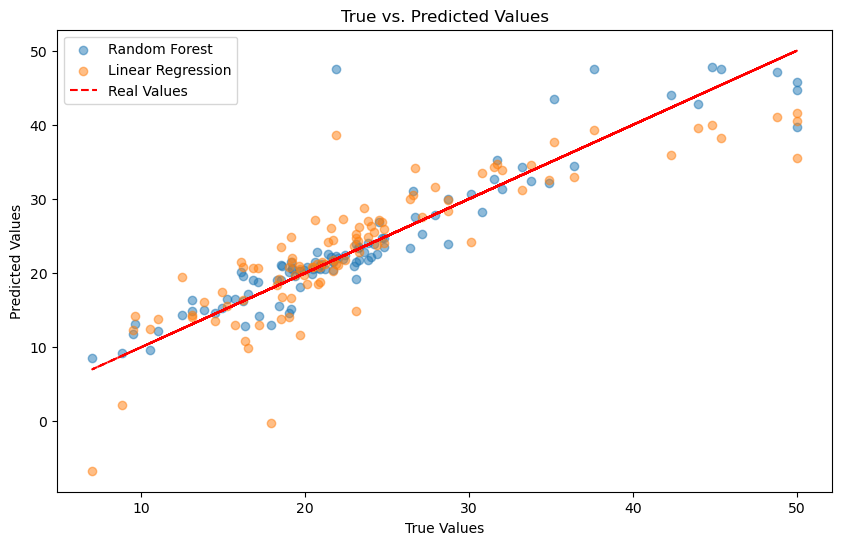

In [42]:
plt.figure(figsize=(10, 6))

# Random Forest predictions
plt.scatter(Y_test, Y_pred_rf, alpha=0.5, label='Random Forest')

# Linear Regression predictions
plt.scatter(Y_test, Y_pred_lineal, alpha=0.5, label='Linear Regression')

# Recta valores reales
plt.plot(Y_test, Y_test, color='red', linestyle='--', label='Real Values')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

En la zona izquierda de la gráfica (valores bajos reales de la variable "target"), la predicción del Random Forest, aún y siendo diferente que el de la regresión lineal, aparece más o menos por la misma zona. En cambio, para valores altos de la variable target (derecha de la gráfica), el Random Forest da predicciones mayores (y más ajustadas) que la regresión lineal, que se desvía más de la recta, quedándose corta para predicciones en el rango de precios alto.

Visualmente, la predicción RF parece más equilibrada, si consideramos todo el rango de valores de precio reales.

# Ejercicio 2

Comparar los modelos en base a MSE y R2.

A continuación cuán mejor o peor es cada regresión (lineal y random forest) en base a su ajuste y acierto prediciendo los valores, así como su error cuadrático medio (MSE).

Observamos los valores para la regresión lineal:

In [43]:
# Regresión lineal:

print(X_train.columns)
print('Coefficients:', regresion_lineal.coef_)
print('Intercept:', regresion_lineal.intercept_)

# Mean Squared Error (MSE)
mse_lineal = mean_squared_error(Y_test, Y_pred_lineal)
print('MSE = '+str(mse_lineal))
# R^2
r2_lineal = r2_score(Y_test, Y_pred_lineal)
print('R^2 = ' + str(r2_lineal))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'RAD_2', 'RAD_3', 'RAD_4', 'RAD_5', 'RAD_6',
       'RAD_7', 'RAD_8', 'RAD_24'],
      dtype='object')
Coefficients: [-0.47189604  0.54171851  1.55197928  2.50334702 -7.23790325  2.85434314
 -0.05360702 -4.63098401 -4.45417668 -8.67473036  0.21973328 -5.89016401
  1.4861762   5.31965701  3.24612127  3.18078321  1.40139645  5.27340461
  5.49493944  7.65724359]
Intercept: 28.838985307592967
MSE = 22.973692910528644
R^2 = 0.7233603849867255


Y aquí, los valores de la regresión mediante "random forest":

In [44]:
print(X_train.columns)
print('Feature Importances:', regresion_rf.feature_importances_)  # Nos da la importancia relativa de cada "feature" en la predicción.

# MSE
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
print('MSE = '+str(mse_rf))
# R^2
r2_rf = r2_score(Y_test, Y_pred_rf)
print('R^2 = ' + str(r2_rf))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'RAD_2', 'RAD_3', 'RAD_4', 'RAD_5', 'RAD_6',
       'RAD_7', 'RAD_8', 'RAD_24'],
      dtype='object')
Feature Importances: [3.94649427e-02 9.18093719e-04 5.52434740e-03 5.75017281e-04
 2.01687603e-02 3.48316759e-01 1.31499984e-02 6.84799195e-02
 1.59765463e-02 1.41767394e-02 1.08713335e-02 4.59578939e-01
 2.35953447e-04 3.46770653e-04 5.16585994e-04 3.98149792e-04
 2.69613698e-04 1.28700782e-04 4.80161057e-04 4.22667696e-04]
MSE = 13.130628068627447
R^2 = 0.8418864608343889


En este caso, y esta vez apoyándonos en números y no en una impresión, claramente podemos decir que el modelo de "Random Forest Regressor" es mejor que el de la regresión lineal.

El motivo es que el coeficiente de determinación R^2 es mayor (0.842 > 0.723), y el error cuadrático medio del Random Forest es menor (13.130 < 22.974). Gráficamente, también se distingue:

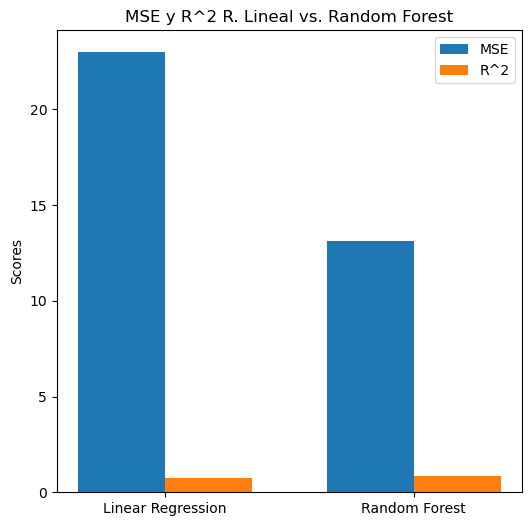

In [45]:
# MSE y R^2
valores_mse = [mse_lineal, mse_rf]
valores_r2 = [r2_lineal, r2_rf]
titulos = ['Linear Regression', 'Random Forest']

x = np.arange(len(titulos))  # Posición...
width = 0.35  # Anchura

fig, ax = plt.subplots(figsize=(6, 6))
rects1 = ax.bar(x - width/2, valores_mse, width, label='MSE')
rects2 = ax.bar(x + width/2, valores_r2, width, label='R^2')

ax.set_ylabel('Scores')
ax.set_title('MSE y R^2 R. Lineal vs. Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(titulos)
ax.legend()

plt.show()

# Ejercicio 3

Entrenar los modelos empleando los diferentes parámetros de los que disponen, para tratar de mejorarlos.

### Regresión Lineal

Los siguientes son los parámetros por defecto usados hace un momento en la regresión lineal:

In [46]:
print('Parameters currently in use:\n')
print(regresion_lineal.get_params())

Parameters currently in use:

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


Podríamos hacer un "grid search" modificando estos y/o algún otro parámetro:

In [50]:
param_grid_lineal = {
    'fit_intercept': [True, False],   # Cálculo de punto de corte en eje Y, o bien corte en (0, 0)
    'n_jobs': [4],  # Simplemente para especificar el número de "cores".
    'positive': [True, False],   # Que los coeficientes de cada variable dentro de la regresión hayan de ser positivos obligatoriamente o no.
}

In [51]:
# Búsqueda dentro de los hiperparámetros decididos
grid_search_lineal = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid_lineal, cv=5, n_jobs=-1, verbose=2)
grid_search_lineal.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False], 'n_jobs': [4],
                         'positive': [True, False]},
             verbose=2)

In [52]:
# ¿Cuáles son los mejores hiperparámetros?
print("Best parameters:", grid_search_lineal.best_params_)

Best parameters: {'fit_intercept': True, 'n_jobs': 4, 'positive': False}


In [53]:
# Lo almacenamos como modelo.
best_linear = grid_search_lineal.best_estimator_

In [54]:
best_linear

LinearRegression(n_jobs=4)

Dado que "n_jobs" se refiere solamente al número de núcleos utilizado para el cálculo, realmente el mejor modelo ya venía a ser el mismo que el modelo por defecto.

### Random Forest

A diferencia del caso de la regresión lineal, en el modelo Random Forest hay bastantes más cosas que podemos modificar. Estos son los parámetros por defecto utilizados en la regresión random forest de antes:

In [55]:
print('Parameters currently in use:\n')
print(regresion_rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


La regresión "random forest" nos ofrece muchos más hiperparámetros que se pueden modificar en busca de un mejor modelo. Se buscará por prueba y error los óptimos, dentro de las opciones que indiquemos.

Podríamos modificar, por ejemplo, unos cuantos de los siguientes hiperparámetros:

-n_estimators, que representa el número de "árboles" en el "bosque" del random forest.

-max_features, que representa el número de variables o rasgos considerados para partir un nodo en dos.

-max_depth, que representa el número de niveles en cada árbol de decisión.

-min_samples_split, que representa el número de datos o "data points" en cada nodo antes de que éste sea partido en dos fragmentos o "ramas".

-min_samples_leaf, el número mínimo de datos o "data points" que debe haber en un "nodo hoja" (i.e. un nodo terminal).

-bootstrap, el método para muestrear los datos o "data points" (ya sea con o sin substitución).

In [57]:
# Hiperparameters grid, las diversas combinaciones de hiperparámetros que probaremos.
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_features': [5, 10, 15, 20],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False],
}

# Búsqueda dentro de los hiperparámetros decididos; ponemos un "fold number" de tres, para no reducir demasiado la muestra de cada fold
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)   # Aquí hacemos el "fit" del nuevo estimador con los diferentes hiperparámetros.

# ¿Cuáles son los mejores hiperparámetros?
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [59]:
# Si quisiéramos, podríamos ver los "scores" de cada una de las combinaciones probadas
'''
print("\nAll Results:")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"Mean Test Score: {mean_score:.3f} for Parameters: {params}")
'''

'\nprint("\nAll Results:")\nfor mean_score, params in zip(grid_search.cv_results_[\'mean_test_score\'], grid_search.cv_results_[\'params\']):\n    print(f"Mean Test Score: {mean_score:.3f} for Parameters: {params}")\n'

En todo caso, el siguiente es el mejor modelo según el GridSearch:

In [60]:
best_rf = grid_search.best_estimator_
#Y_pred = best_model.predict(X_test)

In [61]:
best_rf

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, n_estimators=200)

Bien, pues ahora hagamos nuevas predicciones con la regresión lineal y con el random forest optimizado.

In [62]:
Y_best_linear = best_linear.predict(X_test)
Y_pred_best_rf = best_rf.predict(X_test)

Vuelvo a calcular MSE y R^2 para la regresión lineal modificada y el random forest optimizado.

In [63]:
print(X_train.columns)
print('Coefficients:', best_linear.coef_)
print('Intercept:', best_linear.intercept_)

# MSE
mse_best_linear = mean_squared_error(Y_test, Y_best_linear)
print('MSE = '+str(mse_lineal))
# R^2
r2_best_linear = r2_score(Y_test, Y_best_linear)
print('R^2 = ' + str(r2_lineal))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'RAD_2', 'RAD_3', 'RAD_4', 'RAD_5', 'RAD_6',
       'RAD_7', 'RAD_8', 'RAD_24'],
      dtype='object')
Coefficients: [-0.47189604  0.54171851  1.55197928  2.50334702 -7.23790325  2.85434314
 -0.05360702 -4.63098401 -4.45417668 -8.67473036  0.21973328 -5.89016401
  1.4861762   5.31965701  3.24612127  3.18078321  1.40139645  5.27340461
  5.49493944  7.65724359]
Intercept: 28.838985307592967
MSE = 22.973692910528644
R^2 = 0.7233603849867255


Como ya esperábamos, la regresión lineal "mejorada" da lo mismo que la regresión lineal por defecto.
Pero veamos ahora qué pasa con la regresión Random Forest:

In [64]:
print(X_train.columns)
print('Feature Importances:', best_rf.feature_importances_)  # Nos da la importancia relativa o "peso" de cada "feature" en la predicción.

# Mean squared error (MSE):
mse_best_rf = mean_squared_error(Y_test, Y_pred_best_rf)
print('MSE = '+str(mse_best_rf))
# R^2
r2_best_rf = r2_score(Y_test, Y_pred_best_rf)
print('R^2 = ' + str(r2_best_rf))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'RAD_2', 'RAD_3', 'RAD_4', 'RAD_5', 'RAD_6',
       'RAD_7', 'RAD_8', 'RAD_24'],
      dtype='object')
Feature Importances: [5.78510257e-02 1.50685928e-03 4.17946736e-02 7.08538293e-04
 5.97483984e-02 3.14553247e-01 1.44481631e-02 6.11813204e-02
 2.00399253e-02 3.38946325e-02 1.30977241e-02 3.75293869e-01
 3.50648501e-04 6.94401813e-04 6.57878497e-04 7.11790758e-04
 1.71656081e-04 1.11566471e-04 4.07534524e-04 2.77614650e-03]
MSE = 10.062760200299566
R^2 = 0.8788284444027716


Claramente, se obtiene una mejora.
    
MSE pasa de aprox. 13.130 a ser aprox 10.063. Disminuye, lo cual es bueno.
R^2 pasa de aprox. 0.8570 a ser aprox. 0.879. Aumenta, lo cual es bueno.

Nota: cuando en pruebas iniciales se intentó hacer el "gridsearch" mediante un número de "folds" igual a cinco, en lugar de igual a tres, en ocasiones se obtenían modelos que al verificar su MSE y R^2 eran peores que el modelo por defecto. Esto probablemente se debía a que el modelo estaba utilizando demasiado pocos datos cada vez para hacer sus cálculos de qué modelo estaba siendo mejor.

Representamos los resultados.

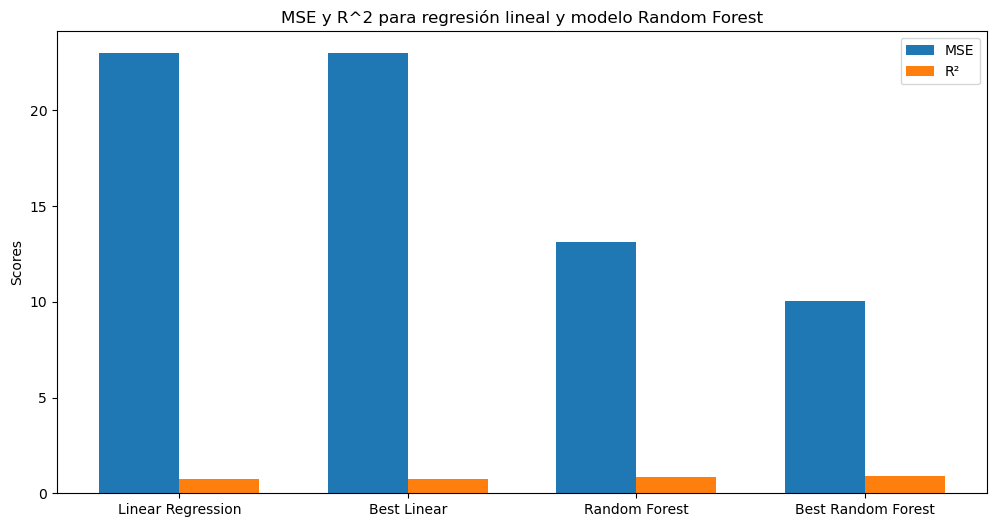

In [65]:
# Updated Metrics
valores_mse = [mse_lineal, mse_best_linear , mse_rf, mse_best_rf]  # Mean Squared Error values
valores_r2 = [r2_lineal, r2_best_linear, r2_rf, r2_best_rf]  # R-squared values
titulos = ['Linear Regression', "Best Linear", 'Random Forest', 'Best Random Forest']

# X locations for the groups
x = np.arange(len(titulos))  
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, valores_mse, width, label='MSE')
rects2 = ax.bar(x + width/2, valores_r2, width, label='R²')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('MSE y R^2 para regresión lineal y modelo Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(titulos)
ax.legend()

plt.show()

En base a lo visto hasta el momento nuestro mejor modelo es el Random Forest optimizado.

# Ejercicio 4

Comparar su rendimiento empleando la aproximación train/test o empleando todos los datos (validación interna).

Se trata de hacer la misma comparación de valores MSE y R^2 pero para -por ejemplo- cinco "folds" diferentes, tomando una muestra diferente de los datos como training y otra diferente como test cada vez. Calcularemos los correspondientes "cross-validation scores" de hacer esos cinco "folds".

In [66]:
Y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

La X y la Y para la validación cruzada serán la totalidad de las que nos habían quedado después de la transformación de variables, pero sin partirlas explícitamente en train y test (eso sucederá durante la creación y testeado con los diferentes "folds").

In [67]:
# Número de "folds" que se harán
num_folds = 5

# Primero creamos un nuevo estimador de cada tipo.
linear_regression_crossval = LinearRegression()
rf_crossval = grid_search.best_estimator_   # Repescamos los valores del que habíamos encontrado que era el óptimo.

# Validación cruzada MSE
mse_crossval_lineal = cross_val_score(linear_regression_crossval , X, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))
mse_crossval_rf = cross_val_score(rf_crossval, X, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))

# Cálculo del MSE promedio
mse_lineal_medio = np.mean(mse_crossval_lineal)
mse_rf_medio = np.mean(mse_crossval_rf)

# Desviación estándar de MSE
std_dev_mse_lineal = np.std(mse_crossval_lineal)
std_dev_mse_rf = np.std(mse_crossval_rf)


# Validación cruzada de R^2
r2_crossval_lineal = cross_val_score(linear_regression_crossval , X, Y, cv=num_folds, scoring='r2')
r2_crossval_rf = cross_val_score(rf_crossval , X, Y, cv=num_folds, scoring='r2')

# Cálculo R^2 medio
r2_lineal_medio = np.mean(r2_crossval_lineal)
r2_rf_medio = np.mean(r2_crossval_rf)

# Desviación estándar de R^2
std_dev_r2_lineal = np.std(r2_crossval_lineal)
std_dev_r2_rf = np.std(r2_crossval_rf)

In [68]:
tabla_MSE_R2 = {
    'Modelo validado': ['Regresión Lineal', 'Random Forest'],
    'R^2 promedio': [r2_lineal_medio, r2_rf_medio],
    'Desv. estándar R^2' : [std_dev_r2_lineal, std_dev_r2_rf],
    'MSE promedio': [mse_lineal_medio, mse_rf_medio],
    'Desv. estándar MSE': [std_dev_mse_lineal, std_dev_mse_rf]
}

pd.DataFrame(tabla_MSE_R2).round(3)


,Modelo validado,R^2 promedio,Desv. estándar R^2,MSE promedio,Desv. estándar MSE
0,Regresión Lineal,0.325,0.411,37.889,22.987
1,Random Forest,0.665,0.180,19.493,9.647


Podemos comprobar como el mejor modelo es el Random forest porque:
    
a) El R^2 promedio es más cercano a uno.

b) La desviación estándar (variabilidad) de R^2 es menor, por lo que el método se comportará de forma más fiable o consistente con diversos sets de datos.

c) El MSE promedio es menor (y con menos variabilidad).

Si miramos los resultados de R^2 de cada modelo para cada "fold", vemos en concreto los siguientes datos:

In [69]:
r2_crossval_lineal

array([ 0.61238312,  0.74278118,  0.5536421 ,  0.08098992, -0.36475742])

In [70]:
r2_crossval_rf

array([0.75697604, 0.84432433, 0.79271443, 0.57628541, 0.35371678])

Es decir, que:

a) En efecto, el método de regresión lineal nos da resultados mucho menos fiables (hasta sale un R^2 negativo, en un "fold").

b) Es llamativo que el "fold" con peor valor de R^2 es el mismo en el caso de la regresión lineal y del RF. Probablemente se deba a que los datos concretos contenidos en ese "fold" son menos adecuados para ser modelizados, al menos por estos modelos.
Esto puede deberse a diferencias importantes entre los datos de "train" y de "test" en ese fold, o bien a las características concretas de los datos en ese fold "rebelde" (lo cual en el fondo puede significar lo mismo).

# Ejercicio 5

Predecir el valor mediano (MEDV), pero sin usar la variable número de habitaciones (RM).

Lo que hemos de hacer aquí es:

-Eliminar la variable "RM" de la X para entrenar un nuevo modelo.

-Volver a crear un regresor, con los parámetros que habíamos encontrado antes como óptimos, para comparar.

-Hacer el ajuste ("fit") para entrenar el modelo.
    
-Hacer las predicciones.

In [71]:
X_test_no_RM = X_test.drop(["RM"], axis=1)
X_test_no_RM.head(1)  # Y_test será la misma del inicio.

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,TAX,PTRATIO,B,LSTAT,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
23,0.203592,0.0,0.281525,0,0.314815,1.0,0.287461,0.229008,0.893617,0.148699,0.851574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_train_no_RM = X_train.drop(["RM"], axis=1)
X_train_no_RM.head(1)  # Y_train será la misma del inicio.

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,TAX,PTRATIO,B,LSTAT,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
7,-0.031143,1.0,0.271628,0,0.286008,0.959835,0.888221,0.236641,0.276596,0.261902,0.778611,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [73]:
# Creamos dos regresores nuevos para "train test" sin RM

regresion_lineal_no_RM = LinearRegression()

regresion_rf_no_RM = grid_search.best_estimator_


Lineal:

In [74]:
# Entrenamos el regresor para la aproximación train-test
regresion_lineal_no_RM.fit(X_train_no_RM, Y_train)
Y_pred_lineal_no_RM = regresion_lineal_no_RM.predict(X_test_no_RM)

In [75]:
# MSE
mse_lineal_no_RM = mean_squared_error(Y_test, Y_pred_lineal_no_RM)
print('MSE = '+str(mse_lineal_no_RM))
# R^2
r2_lineal_no_RM = r2_score(Y_test, Y_pred_lineal_no_RM)
print('R^2 = ' + str(r2_lineal_no_RM))

MSE = 23.638613436191918
R^2 = 0.7153536897222644


Random forest:

In [76]:
# Entrenamos el regresor para la aproximación train-test
regresion_rf_no_RM.fit(X_train_no_RM, Y_train)
Y_pred_rf_no_RM = regresion_rf_no_RM.predict(X_test_no_RM)

In [77]:
# MSE
mse_rf_no_RM = mean_squared_error(Y_test, Y_pred_rf_no_RM)
print('MSE = '+str(mse_rf_no_RM))
# R^2
r2_rf_no_RM = r2_score(Y_test, Y_pred_rf_no_RM)
print('R^2 = ' + str(r2_rf_no_RM))

MSE = 14.105474377502034
R^2 = 0.8301477687297083


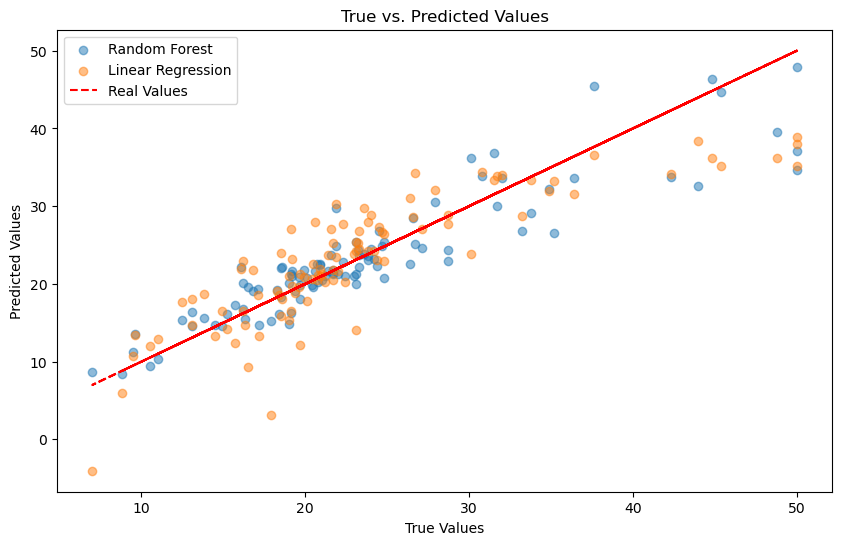

In [78]:
plt.figure(figsize=(10, 6))

# Random Forest predictions
plt.scatter(Y_test, Y_pred_rf_no_RM, alpha=0.5, label='Random Forest')

# Linear Regression predictions
plt.scatter(Y_test, Y_pred_lineal_no_RM, alpha=0.5, label='Linear Regression')

# Recta valores reales
plt.plot(Y_test, Y_test, color='red', linestyle='--', label='Real Values')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Para comenzar, no se ve tanta diferencia como en la primera predicción entre el modelo lineal y el Random Forest. Si la guía fuese lo que nos dice la vista, sería algo más difícil que con los modelos por defecto decantarse por uno u otro.

Volveremos a hacer ahora la validación cruzada:

In [79]:
Y  # Y será la misma.

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

In [80]:
X_no_RM = X.drop(['RM'], axis=1)   # A la X le hemos de quitar la variable "RM".
X_no_RM

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,TAX,PTRATIO,B,LSTAT,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,0.067815,0,0.314815,0.641607,0.285777,0.208015,0.287234,0.261902,-0.637681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.063755,0.00,0.242302,0,0.172840,0.782698,0.569789,0.104962,0.553191,0.261902,-0.221889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.063760,0.00,0.242302,0,0.172840,0.599382,0.569789,0.104962,0.553191,0.066675,-0.732634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.062347,0.00,0.063050,0,0.150206,0.441813,0.924391,0.066794,0.648936,0.153016,-0.841579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.052144,0.00,0.063050,0,0.150206,0.528321,0.924391,0.066794,0.648936,0.261902,-0.602699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.681771,-0.236007,0.164122,0.893617,0.026382,-0.168916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,-0.058759,0.00,0.420455,0,0.386831,0.760041,-0.297887,0.164122,0.893617,0.261902,-0.227886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503,-0.054450,0.00,0.420455,0,0.386831,0.907312,-0.336744,0.164122,0.893617,0.261902,-0.571714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,-0.040867,0.00,0.420455,0,0.386831,0.889804,-0.265053,0.164122,0.893617,0.096414,-0.487756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Para validación cruzada, creamos nuevo estimador de cada tipo
regresion_lineal_crossval_no_RM = LinearRegression()   # Usamos los valores por defecto, dado que no hay cambio.
regresion_rf_crossval_no_RM = grid_search.best_estimator_  # Usaremos los parámetros de la optimización que hicimos más arriba.

In [82]:
# Número de "folds" que se harán
num_folds = 5

# Validación cruzada de MSE
mse_lineal_no_RM = cross_val_score(regresion_lineal_crossval_no_RM , X_no_RM, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))
mse_rf_no_RM = cross_val_score(regresion_rf_crossval_no_RM, X_no_RM, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))

# Cálculo del MSE promedio
mse_lineal_medio_no_RM = np.mean(mse_lineal_no_RM)
mse_rf_medio_no_RM = np.mean(mse_rf_no_RM)

# Validación cruzada de R^2
r2_lineal_no_RM = cross_val_score(regresion_lineal_crossval_no_RM , X_no_RM, Y, cv=num_folds, scoring='r2')
r2_rf_no_RM = cross_val_score(regresion_rf_crossval_no_RM, X_no_RM, Y, cv=num_folds, scoring='r2')

# Calculate average R²
r2_lineal_medio_no_RM = np.mean(r2_lineal_no_RM)
r2_rf_medio_no_RM = np.mean(r2_rf_no_RM)

# Print the results
print("Linear Regression - MSE medio:", mse_lineal_medio_no_RM, "R^2 medio:", r2_lineal_medio_no_RM)
print("Random Forest - MSE medio:", mse_rf_medio_no_RM, "R^2 medio:", r2_rf_medio_no_RM)
print("\n")
print("Folds lineal - MSE", mse_lineal_no_RM)
print("Folds lineal - R^2", r2_lineal_no_RM)
print()
print("Folds RF - MSE", mse_rf_no_RM)
print("Folds RF - R^2", r2_rf_no_RM)


Linear Regression - MSE medio: 31.231563939216926 R^2 medio: 0.4764859209697515
Random Forest - MSE medio: 25.974129498153026 R^2 medio: 0.5390253830302154


Folds lineal - MSE [20.03977992 30.75624668 48.38860299 39.96768342 17.00550668]
Folds lineal - R^2 [0.41972878 0.66215572 0.39580106 0.54432973 0.36041432]

Folds RF - MSE [12.49228232 19.8274825  45.60542477 32.19630271 19.74915519]
Folds RF - R^2 [0.62379306 0.7873977  0.39143907 0.64640865 0.24608843]


Ambos modelos han empeorado mucho, de lo cual deducimos que RM era una variable clave para predecir con éxito "MEDV", el precio de los pisos.

Si nos fijamos en el R^2 promedio, ha empeorado en ambos casos. Lo mismo ha pasado en el caso del MSE, habiendo un empeoramiento mayor en el caso del Random Forest (pese a todo, sigue siendo marginalmente mejor).

Si nos fijamos en los "Folds", hay una "mediocrización general" de de los valores de R^2. En este caso, la excepción es el obtener alguno más o menos bueno. Los valores de MSE se disparan.

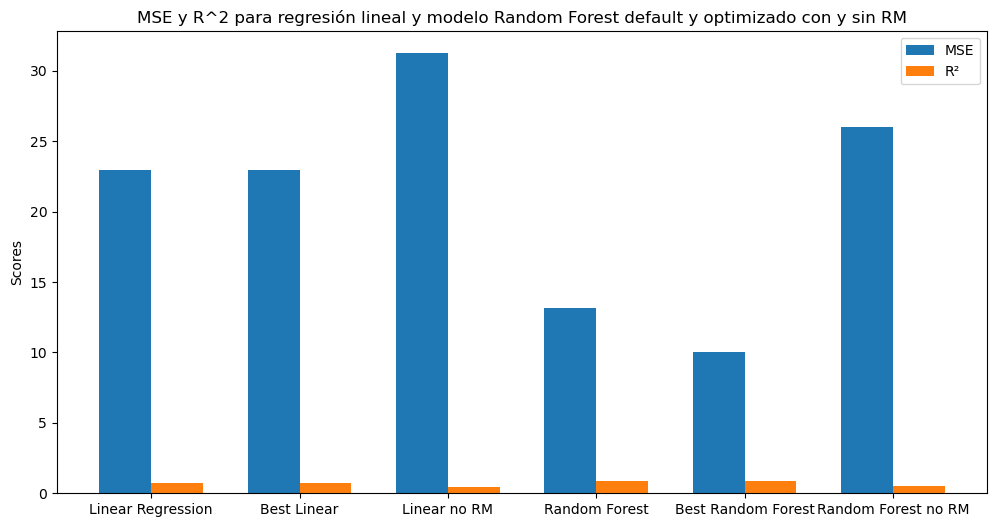

In [88]:
# Updated Metrics
valores_mse = [mse_lineal, mse_best_linear, mse_lineal_medio_no_RM, mse_rf, mse_best_rf, mse_rf_medio_no_RM]  # Mean Squared Error values
valores_r2 = [r2_lineal, r2_best_linear, r2_lineal_medio_no_RM, r2_rf, r2_best_rf, r2_rf_medio_no_RM]  # R-squared values
titulos = ['Linear Regression', "Best Linear", "Linear no RM", 'Random Forest', 'Best Random Forest', "Random Forest no RM"]

# X locations for the groups
x = np.arange(len(titulos))  
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, valores_mse, width, label='MSE')
rects2 = ax.bar(x + width/2, valores_r2, width, label='R²')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('MSE y R^2 para regresión lineal y modelo Random Forest default y optimizado con y sin RM')
ax.set_xticks(x)
ax.set_xticklabels(titulos)
ax.legend()

plt.show()

La conclusión es clara: mala idea quitar la variable "RM", si lo que pretendemos es predecir certeramente el precio "MEDV" de los pisos. Algo esperable, ya que en el pairplot vimos que "RM" era la única variable que tenía una correlación lineal con el precio, "MEDV".